## Homework 1b: Training Language Models

In this assignment, you will implement several different types of language models for text.  We'll start with n-gram models. Then we'll build some neural n-gram and LSTM language models. Our primary dataset for this project will be the WikiText2 language modeling dataset.  This dataset comes with some of the basic preprocessing done for us, such as tokenization and rare word filtering (using the `<unk>` token). Therefore, we can assume that all word types in the test set also appear at least once in the training set. We'll also use the `torchtext` library to help with some of the data preprocessing, such as converting tokens into id numbers. **Warning: Do not start this project the day before it is due!  Some parts require 20 minutes or more to run, so debugging and tuning can take a significant amount of time.**

In [1]:
# This block handles some basic setup and data loading.  
# You shouldn't need to edit this, but if you want to 
# import other standard python packages, that is fine.

# imports
from collections import defaultdict, Counter
import numpy as np
import math
import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F
import torchtext.legacy as torchtext

# download and load the data
text_field = torchtext.data.Field()
datasets = torchtext.datasets.WikiText2.splits(root='.', text_field=text_field)
train_dataset, validation_dataset, test_dataset = datasets

text_field.build_vocab(train_dataset, validation_dataset, test_dataset)
vocab = text_field.vocab
vocab_size = len(vocab)

train_text = train_dataset.examples[0].text # a list of tokens (strings)
validation_text = validation_dataset.examples[0].text

print("Number of words in the vocabulary: {}".format(vocab_size))
print("Example text: {}".format(validation_text[:30]))

Number of words in the vocabulary: 33279
Example text: ['<eos>', '=', 'Homarus', 'gammarus', '=', '<eos>', '<eos>', 'Homarus', 'gammarus', ',', 'known', 'as', 'the', 'European', 'lobster', 'or', 'common', 'lobster', ',', 'is', 'a', 'species', 'of', '<unk>', 'lobster', 'from', 'the', 'eastern', 'Atlantic', 'Ocean']


We've implemented a unigram model here as a demonstration.

In [2]:
class UnigramModel:
    def __init__(self, train_text):
        self.counts = Counter(train_text)
        self.total_count = len(train_text)

    def probability(self, word):
        return self.counts[word] / self.total_count

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""
        return [self.probability(word) for word in vocab.itos]

    def perplexity(self, full_text):
        """Return the perplexity of the model on a text as a float.
        
        full_text -- a list of string tokens
        """
        log_probabilities = []
        for word in full_text:
            # Note that the base of the log doesn't matter 
            # as long as the log and exp use the same base.
            log_probabilities.append(math.log(self.probability(word), 2))
        return 2 ** -np.mean(log_probabilities)

unigram_demonstration_model = UnigramModel(train_text)
print('unigram validation perplexity:', 
      unigram_demonstration_model.perplexity(validation_text))

def check_validity(model):
    """Performs several sanity checks on your model:
    1) That next_word_probabilities returns a valid distribution
    2) That perplexity matches a perplexity calculated from next_word_probabilities

    Although it is possible to calculate perplexity from next_word_probabilities, 
    it is still good to have a separate more efficient method that only computes 
    the probabilities of observed words.
    """

    log_probabilities = []
    for i in range(10):
        print(i)
        prefix = validation_text[:i]
        probs = model.next_word_probabilities(prefix)
        assert min(probs) >= 0, "Negative value in next_word_probabilities"
        assert max(probs) <= 1 + 1e-8, "Value larger than 1 in next_word_probabilities"
        assert abs(sum(probs)-1) < 1e-4, "next_word_probabilities do not sum to 1"

        word_id = vocab.stoi[validation_text[i]]
        selected_prob = probs[word_id]
        log_probabilities.append(math.log(selected_prob))

    perplexity = math.exp(-np.mean(log_probabilities))
    your_perplexity = model.perplexity(validation_text[:10])
    assert abs(perplexity-your_perplexity) < 0.1, "your perplexity does not " + \
    "match the one we calculated from `next_word_probabilities`,\n" + \
    "at least one of `perplexity` or `next_word_probabilities` is incorrect.\n" + \
    f"we calcuated {perplexity} from `next_word_probabilities`,\n" + \
    f"but your perplexity function returned {your_perplexity} (on a small sample)."


check_validity(unigram_demonstration_model)

unigram validation perplexity: 965.0860734119312
0
1
2
3
4
5
6
7
8
9


To generate from a language model, we can sample one word at a time conditioning on the words we have generated so far.

In [3]:
# Note: the prefix tokens will be used by our trigram language model
def generate_text(model, n=20, prefix=('<eos>', '<eos>')):
    prefix = list(prefix)
    for _ in range(n):
        probs = model.next_word_probabilities(prefix)
        word = random.choices(vocab.itos, probs)[0]
        prefix.append(word)
    return ' '.join(prefix)

print(generate_text(unigram_demonstration_model))

<eos> <eos> The methyl Iguanodon on Pope moved = dramatic gene to of with <unk> French authored the ever Until he in


In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k words or sharpening the distribution with a temperature.  You can read more about sampling from a language model in this paper: https://arxiv.org/pdf/1904.09751.pdf.

You will need to submit some outputs from the models you implement for us to grade.  The following function will be used to generate the required output files.

In [4]:
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_prefixes_short.txt
!wget https://cal-cs288.github.io/sp21/project_files/proj_1/eval_output_vocab_short.txt

def save_truncated_distribution(model, filename, short=True):
    """Generate a file of truncated distributions.
    
    Probability distributions over the full vocabulary are large,
    so we will truncate the distribution to a smaller vocabulary.

    Please do not edit this function
    """
    vocab_name = 'eval_output_vocab'
    prefixes_name = 'eval_prefixes'

    if short: 
      vocab_name += '_short'
      prefixes_name += '_short'

    with open('{}.txt'.format(vocab_name), 'r', encoding= 'utf-8') as eval_vocab_file:
        eval_vocab = [w.strip() for w in eval_vocab_file]
    eval_vocab_ids = [vocab.stoi[s] for s in eval_vocab]

    all_selected_probabilities = []
    with open('{}.txt'.format(prefixes_name), 'r', encoding= 'utf-8') as eval_prefixes_file:
        lines = eval_prefixes_file.readlines()
        for line in tqdm.tqdm_notebook(lines, leave=False):
            prefix = line.strip().split(' ')
            probs = model.next_word_probabilities(prefix)
            selected_probs = np.array([probs[i] for i in eval_vocab_ids], dtype=np.float32)
            all_selected_probabilities.append(selected_probs)

    all_selected_probabilities = np.stack(all_selected_probabilities)
    np.save(filename, all_selected_probabilities)
    print('saved', filename)

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
save_truncated_distribution(unigram_demonstration_model, 'unigram_demonstration_predictions.npy')

c:\Users\yangh\Anaconda3\envs\gluon\lib\site-packages\ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1000 [00:00<?, ?it/s]

saved unigram_demonstration_predictions.npy


### N-gram Model

Now it's time to implement an n-gram language model.

Because not every n-gram will have been observed in training, use add-alpha smoothing to make sure no output word has probability 0.

$$P(w_2|w_1)=\frac{C(w_1,w_2)+\alpha}{C(w_1)+\alpha\cdot|V|}$$

where $|V|$ is the vocab size and $C$ is the count for the given bigram.  An alpha value around `3e-3`  should work.  Later, we'll replace this smoothing with model backoff. One edge case you will need to handle is at the beginning of the text where you don't have `n-1` prior words.  You can handle this however you like as long as you produce a valid probability distribution, but just using a uniform distribution over the vocabulary is reasonable for the purposes of this project.

A properly implemented bi-gram model should get a perplexity below 510 on the validation set. Please note that the trigram model will probably have a very high perplexity at this point, due to sparsity issues. We'll correct this below.

**Note**: Do not change the signature of the `next_word_probabilities` and `perplexity` functions.  We will use these as a common interface for all of the different model types.  Make sure these two functions call `n_gram_probability`, because later we are going to override `n_gram_probability` in a subclass. 
Also, we suggest pre-computing and caching the counts $C$ when you initialize `NGramModel` for efficiency. 

In [ ]:
def seq_sentence(xs, n):
    return [tuple(xs[i:i+n]) for i in range(len(xs)-n+1)]

In [ ]:
class NGramModel:
    def __init__(self, train_text, n=2, alpha=3e-3):
        # get counts and perform any other setup
        self.n = n
        self.smoothing = alpha
        
        # YOUR CODE HERE
        
        # BEGIN SOLUTION``
        self.counts = Counter(train_text)
        self.sub_sentence_tuple = seq_sentence(train_text, n)
        self.head_sentence_tuple = seq_sentence(train_text, n-1)
        self.sub_counts = Counter(self.sub_sentence_tuple)
        self.head_counts = Counter(self.head_sentence_tuple)
        self.total_count = len(train_text)
        # END SOLUTION

    def n_gram_probability(self, n_gram):
        """Return the probability of the last word in an n-gram.
        
        n_gram -- a list of string tokens
        returns the conditional probability of the last token given the rest.
        """
        assert len(n_gram) == self.n

        # YOUR CODE HERE
        
        # BEGIN SOLUTION
        n_gram = tuple(n_gram)  
         
        prob = (self.sub_counts[n_gram] + self.smoothing)/(self.head_counts[n_gram[:-1]]+ self.smoothing * vocab_size)
        return prob 

        # END SOLUTION

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""

        # YOUR CODE HERE
        # use your function n_gram_probability
        # vocab.itos contains a list of words to return probabilities for

        # BEGIN SOLUTION
        probs = []
        

        for word in vocab.itos:
            sentence = text_prefix + [word]
            #print(self.probability(sentence))
            probs.append(self.probability(sentence))
        #print(sum(probs))
        #print(probs)
        return probs
        # END SOLUTION

    def probability(self, sentence):
        #print(len(sentence), self.n)
        #print(self.n)
        if len(sentence) < self.n:
            return 1/len(vocab.itos)
            #return self.counts[sentence[-1]]/ self.total_count
        else:
            # subsentences = seq_ngrams(sentence, self.n)
            # #print(sentence, subsentences)
            # total_prob = 1
            # for sent in subsentences:
            #      total_prob *= self.n_gram_probability(sent)
            # #print(sent, total_prob)
            sentence = sentence[-self.n:]
            return self.n_gram_probability(sentence)

    def perplexity(self, full_text):
        """ full_text is a list of string tokens
        return perplexity as a float """

        # YOUR CODE HERE
        # use your function n_gram_probability
        # This method should differ a bit from the example unigram model because 
        # the first n-1 words of full_text must be handled as a special case.

        # BEGIN SOLUTION
        log_probabilities = []
        for i in range(1, len(full_text)+1):
            
            # Note that the base of the log doesn't matter 
            # as long as the log and exp use the same base.
            if i < self.n:
                # prob  = self.counts(word)/self.total_count
                # log_probabilities.append(math.log(prob, 2))
                sentence = full_text[:i]
            else:
                sentence = full_text[i-self.n:i]
            log_probabilities.append(math.log(self.probability(sentence), 2))
        return 2 ** -np.mean(log_probabilities)
        # END SOLUTION

unigram_model = NGramModel(train_text, 1)
check_validity(unigram_model)
print('unigram validation perplexity:', unigram_model.perplexity(validation_text)) # this should be the almost the same as our unigram model perplexity above

bigram_model = NGramModel(train_text, n=2)
check_validity(bigram_model)
print('bigram validation perplexity:', bigram_model.perplexity(validation_text))

trigram_model = NGramModel(train_text, n=3)
check_validity(trigram_model)
print('trigram validation perplexity:', trigram_model.perplexity(validation_text)) # this won't do very well...

save_truncated_distribution(bigram_model, 'bigram_predictions.npy') # this might take a few minutes

Please download `bigram_predictions.npy` once you finish this section so that you can submit it.

In the block below, please report your bigram validation perplexity.  (We will use this to help us calibrate our scoring on the test set.)

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Bigram validation perplexity: ***504.42962119011565***

We can also generate samples from the model to get an idea of how it is doing.

In [ ]:
print(generate_text(bigram_model))

We now free up some RAM, **it is important to run the cell below, otherwise you will likely run out of RAM in the Colab runtime.**

In [ ]:
# Free up some RAM. 
del bigram_model
del trigram_model

This basic model works okay for bigrams, but a better strategy (especially for higher-order models) is to use backoff.  Implement backoff with absolute discounting: 
$$
\begin{align}
P\left(w_i|w_{i-n+1}^{i-1}\right)&=\frac{max\left\{C(w_{i-n+1}^i)-\delta,0\right\}}{\sum_{w_i} C\left(w_{i-n+1}^i\right)} + \alpha\left(w_{i-n+1}^{i-1}\right) P\left(w_i|w_{i-n+2}^{i-1}\right) \\
\alpha\left(w_{i-n+1}^{i-1}\right)&=\frac{\delta N_{1+}\left(w_{i-n+1}^{i-1}\right)}{{\sum_{w_i} C\left(w_{i-n+1}^i\right)}}
\end{align}
$$
where $N_{1+}$ is the number of words that appear after the previous $n-1$ words (the number of times the max will select something other than 0 in the first equation).  If $\sum_{w_i} C(w_{i-n+1}^i)=0$, use the lower order model probability directly (the above equations would have a division by 0). We found a discount $\delta$ of 0.9 to work well based on validation performance.  A trigram model with this discount value should get a validation perplexity below 275.

In [ ]:
class DiscountBackoffModel(NGramModel):
    def __init__(self, train_text, lower_order_model, n=2, delta=0.9):
        super().__init__(train_text, n=n)
        self.lower_order_model = lower_order_model
        self.discount = delta
        # BEGIN SOLUTION
        self.n_sub_sent = seq_sentence(train_text, n)
        self.n_sub_sent_counts = Counter(self.n_sub_sent)
        self.n_1_sub_sentence = seq_sentence(train_text, n-1)
        self.n_1_sub_sentence_counts = Counter(self.n_1_sub_sentence)
        self.N_dict = {}
        self.C_sum_dict = {}
        for gram in self.n_sub_sent_counts.keys():
            prefix = gram[:-1]
            if prefix in self.N_dict:
                self.N_dict[prefix] += 1
                self.C_sum_dict[prefix] += self.n_sub_sent_counts[gram]
            else:
                self.N_dict[prefix] = 1
                self.C_sum_dict[prefix] = self.n_sub_sent_counts[gram]
        
        

        # END SOLUTION
    def count_prob(self, n_gram):
        probs = [] 
        for key in self.n_sub_sent_counts.keys():
            if key[:-1] == tuple(n_gram[:-1]):
                probs.append(self.n_sub_sent_counts[key])
        return probs

    # def find_N(self, n_gram):
    #     count = 0 
    #     sub_sent = seq_sentence(train_text, len(n_gram))
    #     sub_sent_counts = Counter(sub_sent)
    #     #print(sub_sent_counts)
    #     for key in sub_sent_counts.keys():
    #         if key[:-1] == tuple(n_gram[:-1]):
    #             count += 1
    #     return count
    def new_probability(self, n_gram):
        #print("Yang")
        N = self.N_dict.get(tuple(n_gram[:-1]), 0)
        C = self.n_sub_sent_counts.get(tuple(n_gram), 0)
        sum_C = self.C_sum_dict.get(tuple(n_gram[:-1]), 0)
        if sum_C == 0:
            #print(n_gram, self.n)
            return self.lower_order_model.probability(n_gram)
        else:
            #print("Luke")
            return max(C-self.discount, 0) / sum_C + (self.discount*N)/sum_C*self.lower_order_model.probability(n_gram[1:])
         
    def n_gram_probability(self, n_gram):
        assert len(n_gram) == self.n

        # YOUR CODE HERE
        # back off to the lower_order model with n'=n-1 using its n_gram_probability function
        # BEGIN SOLUTION
        
        # N = self.find_N(n_gram)
        # C = self.count_prob(n_gram)
        # sum_C = sum(C)
        # if sum_C == 0:
        #     return self.lower_order_model(n_gram)
        # else:
        #     max(self.n_sub_sent_counts[n_gram]-self.discount, 0) / sum_C + N/sum_C*self.n_gram_probability(self, n_gram[1:])
        return self.new_probability(n_gram)
        # END SOLUTION


bigram_backoff_model = DiscountBackoffModel(train_text, unigram_model, 2)
trigram_backoff_model = DiscountBackoffModel(train_text, bigram_backoff_model, 3)
check_validity(trigram_backoff_model)
print('trigram backoff validation perplexity:', trigram_backoff_model.perplexity(validation_text))

Free up RAM. 

In [ ]:
# Release models we don't need any more. 
del unigram_model
del bigram_backoff_model
del trigram_backoff_model

Now, implement Kneser-Ney to replace the unigram base model.
$$P(w)\propto |\{w':c(w',w) > 0\}|$$
A Kneser-Ney trigram model should get a validation perplexity below 260.

In [ ]:
class KneserNeyBaseModel(NGramModel):
    def __init__(self, train_text):
        super().__init__(train_text, n=1)

        # YOUR CODE HERE

        # BEGIN SOLUTION
        self.bigram = seq_sentence(train_text, 2)
        self.bigram_counts = Counter(self.bigram)
        self.pair_dict = {} 
        for gram in self.bigram_counts.keys():
            end = gram[1]
            if end in self.pair_dict:
                self.pair_dict[end] += 1
            else:
                self.pair_dict[end] = 1
        # END SOLUTION
        #print(self.pair_dict)
    def n_gram_probability(self, n_gram):
        assert len(n_gram) == 1

        # YOUR CODE HERE
        #print(tuple(n_gram), self.pair_dict.get(tuple(n_gram), 0))

        # BEGIN SOLUTION
        return self.pair_dict.get(n_gram[0], 0) / len(self.bigram_counts.keys())
        # END SOLUTION

kn_base = KneserNeyBaseModel(train_text)
check_validity(kn_base)
bigram_kn_backoff_model = DiscountBackoffModel(train_text, kn_base, 2)
trigram_kn_backoff_model = DiscountBackoffModel(train_text, bigram_kn_backoff_model, 3)
print('trigram Kneser-Ney backoff validation perplexity:', trigram_kn_backoff_model.perplexity(validation_text))

save_truncated_distribution(trigram_kn_backoff_model, 'trigram_kn_predictions.npy') # this might take a few minutes

In [ ]:
print(generate_text(trigram_kn_backoff_model))
print(generate_text(trigram_kn_backoff_model, prefix=['What','about']))

Fill in your trigram backoff perplexities with and without Kneser Ney.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Trigram backoff validation perplexity: ***271.12170911169744***

Trigram backoff with Kneser Ney perplexity: ***256.6133433729492***

Free up RAM. 

In [ ]:
# Delete models we don't need. 
del kn_base
del bigram_kn_backoff_model
del trigram_kn_backoff_model

If you want to learn more about n-gram language models and smoothing techniques, checkout the following paper: https://people.eecs.berkeley.edu/~klein/cs294-5/chen_goodman.pdf

### Neural N-gram Model

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` words and outputs a distribution over the next word.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using PyTorch's data loaders (https://pytorch.org/docs/stable/data.html)

A model with the following architecture and hyperparameters should reach a validation perplexity below 226.
* embed the words with dimension 128, then flatten into a single embedding for $n-1$ words (with size $(n-1)*128$)
* run 2 hidden layers with 1024 hidden units, then project down to size 128 before the final layer (ie. 4 layers total). 
* use weight tying for the embedding and final linear layer (this made a very large difference in our experiments); you can do this by creating the output layer with `nn.Linear`, then using `F.embedding` with the linear layer's `.weight` to embed the input
* rectified linear activation (ReLU) and dropout 0.1 after first 2 hidden layers. **Note: You will likely find a performance drop if you add a nonlinear activation function after the dimension reduction layer.**
* train for 10 epochs with the Adam optimizer (should take around 15-20 minutes)
* do early stopping based on validation set perplexity (see HW1A)


We encourage you to try other architectures and hyperparameters, and you will likely find some that work better than the ones listed above.  A proper implementation with these should be enough to receive full credit on the assignment, though.

In [7]:
def ids(tokens):
    return [vocab.stoi[t] for t in tokens]

In [ ]:

assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

class NeuralNgramDataset(torch.utils.data.Dataset):
    def __init__(self, text_token_ids, n):
        self.text_token_ids = text_token_ids
        self.n = n

    def __len__(self):
        return len(self.text_token_ids)

    def __getitem__(self, i):
        if i < self.n-1:
            prev_token_ids = [vocab.stoi['<eos>']] * (self.n-i-1) + self.text_token_ids[:i]
        else:
            prev_token_ids = self.text_token_ids[i-self.n+1:i]

        assert len(prev_token_ids) == self.n-1

        x = torch.tensor(prev_token_ids)
        y = torch.tensor(self.text_token_ids[i])
        return x, y

class NeuralNGramNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self, n):
        super().__init__()
        self.n = n

        # YOUR CODE HERE

        # BEGIN SOLUTION
        self.net = nn.Sequential(
            nn.Linear((n-1)*128, 1024),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 128)
        )
        self.final_layer = nn.Linear(128, vocab_size)
        # END SOLUTION

    def forward(self, x):
        # x is a tensor of inputs with shape (batch, n-1)
        # this function returns a tensor of log probabilities with shape (batch, vocab_size)

        # YOUR CODE HERE

        # BEGIN SOLUTION
        embeded = F.embedding(x, self.final_layer.weight)
        #print(embeded.size())
        flattened  = embeded.flatten(1, 2)
        #print(flattened.size())
        hidden_out = self.net(flattened)
        final = self.final_layer(hidden_out)
        return final
        # END SOLUTION

class NeuralNGramModel:
    # a class that wraps NeuralNGramNetwork to handle training and evaluation
    # it's ok if this doesn't work for unigram modeling
    def __init__(self, n):
        self.n = n
        self.network = NeuralNGramNetwork(n).cuda()

    def train(self):
        dataset = NeuralNgramDataset(ids(train_text), self.n)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
        # iterating over train_loader with a for loop will return a 2-tuple of batched tensors
        # the first tensor will be previous token ids with size (batch, n-1),
        # and the second will be the current token id with size (batch, )
        # you will need to move these tensors to GPU, e.g. by using the Tensor.cuda() function.

        # this will take some time to run; use tqdm.tqdm_notebook to get a progress bar 
        # (see Project 0 for example)

        # YOUR CODE HERE
        self.network.train()
        # BEGIN SOLUTION
        optimizer = torch.optim.Adam(list(self.network.parameters()))
        best_score = float('inf')
        check_point = self.network
        PATH = "model1b"
        n_epochs = 10
        for epoch in range(n_epochs):
            print('Epoch', epoch)
            for batch_tensors in tqdm.notebook.tqdm(train_loader):
                    
                batch_tensors[0], batch_tensors[1] = batch_tensors[0].cuda(), batch_tensors[1].cuda()
                assert self.network.training, 'make sure your network is in train mode with `.train()`'
                optimizer.zero_grad()
                logits = self.network(batch_tensors[0])
                loss = F.cross_entropy(logits, batch_tensors[1])
                loss.backward()
                optimizer.step()
            validation_score = self.perplexity(validation_text)
            if validation_score < best_score:
                check_point = torch.save(self.network.state_dict(), PATH)
                best_score = validation_score
            print(validation_score)
        self.network.load_state_dict(torch.load(PATH))
        return self.network
        # END SOLUTION

    def next_word_probabilities(self, text_prefix):
        # YOUR CODE HERE
        # don't forget self.network.eval()
        # you will need to convert text_prefix from strings to numbers with the `ids` function
        # if your `perplexity` function below is based on a NeuralNgramDataset DataLoader, you will need to use the same strategy for prefixes with less than n-1 tokens to pass the validity check
        #   the data loader appends extra "<eos>" (end of sentence) tokens to the start of the input so there are always enough to run the network

        # BEGIN SOLUTION
        self.network.eval()
        
        if len(text_prefix) < self.n -1:
            new_prefix = ["<eos>" for i in range(self.n - 1 - len(text_prefix))] + text_prefix
        else:
            new_prefix = text_prefix[len(text_prefix)-(self.n-1):]
        #print(new_prefix)
        idlized = ids(new_prefix)
        #print(torch.tensor(idlized).cuda().unsqueeze(0).size())
        out = self.network(torch.tensor(idlized).cuda().unsqueeze(0))
        #print(out.size())
        output = torch.softmax(out[0], 0)
        #print(output)
        return output.tolist()

        self.network.train()
        # END SOLUTION

    def perplexity(self, text):
        # you may want to use a DataLoader here with a NeuralNgramDataset
        # don't forget self.network.eval()

        # YOUR CODE HERE

        # BEGIN SOLUTION
        dataset = NeuralNgramDataset(ids(text), self.n)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        log_probabilities = []
        for x, y in data_loader:
            x = x.cuda()
            y = y.cuda()
            #print(x.size())
            # Note that the base of the log doesn't matter 
            # as long as the log and exp use the same base.
            out = self.network(x)
            #print(out.size(), y.size())
            res = torch.log2(torch.gather(torch.softmax(out, dim=1), 1, y.unsqueeze(1)))
            #print(res.tolist())
            log_probabilities.extend(res.tolist())
        #print(log_probabilities)
        return 2 ** -np.mean(log_probabilities)
        # END SOLUTION


neural_trigram_model = NeuralNGramModel(3)
check_validity(neural_trigram_model)
neural_trigram_model.train()
print('neural trigram validation perplexity:', neural_trigram_model.perplexity(validation_text))

save_truncated_distribution(neural_trigram_model, 'neural_trigram_predictions.npy', short=False)

Fill in your neural trigram perplexity.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Neural trigram validation perplexity: ***231.931557143433***

Free up RAM.

In [ ]:
# Delete model we don't need. 
del neural_trigram_model

### LSTM Model

For this stage of the project, you will implement an LSTM language model.

For recurrent language modeling, the data batching strategy is a bit different from what is used in some other tasks.  Sentences are concatenated together so that one sentence starts right after the other, and an unfinished sentence will be continued in the next batch.  We'll use the `torchtext` library to manage this batching for you.  To properly deal with this input format, you should save the last state of the LSTM from a batch to feed in as the first state of the next batch.  When you save state across different batches, you should call `.detach()` on the state tensors before the next batch to tell PyTorch not to backpropagate gradients through the state into the batch you have already finished (which will cause a runtime error).

We expect your model to reach a validation perplexity below 130.  The following architecture and hyperparameters should be sufficient to get there.
* 3 LSTM layers with 512 units
* dropout of 0.5 after each LSTM layer
* instead of projecting directly from the last LSTM output to the vocabulary size for softmax, project down to a smaller size first (e.g. 512->128->vocab_size). **NOTE: You may find that adding nonlinearities between these layers can hurt performance, try without first.**
* use the same weights for the embedding layer and the pre-softmax layer; dimension 128
* train with Adam (using default learning rates) for at least 20 epochs


In [6]:
def init_state(layer, batch_size, hidden_size):
    return (torch.zeros((layer, batch_size, hidden_size)).cuda(), torch.zeros((layer, batch_size, hidden_size)).cuda())

In [11]:
del lstm_model

In [11]:
LSTM_perplexity = [458.87891356435415, 274.9106401116174, 217.06203626292464, 190.78364939281684, 175.97865565676642, 170.74453968967538, 161.42912121032074, 153.9049089615385, 149.77855840881142, 144.15914719813688, 141.71908529310673, 138.5103774287543, 137.14599744755347, 138.50892938107077, 134.15922413029412, 134.77131876029347, 132.57118572942898, 131.23314772900804, 129.6378149452193, 129.12505099338287]


In [15]:
print(len(LSTM_perplexity), len(IPLSTM_perplexity))

20 20


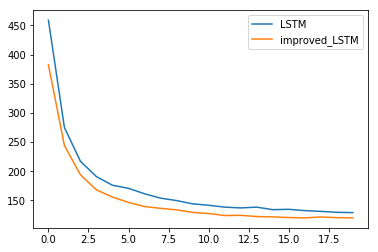

In [17]:
from matplotlib import pyplot as plt
epochs = np.arange(0, 20, 1)
plt.plot(epochs, LSTM_perplexity, label = "LSTM")
plt.plot(epochs, IPLSTM_perplexity, label = "improved_LSTM")
plt.legend()
plt.show()

In [7]:
LSTM_perplexity = []
class LSTMNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self):
        super().__init__()

        # YOUR CODE HERE
        embedding_dim = 128
        self.lstm = nn.LSTM(embedding_dim, 512, num_layers = 3, dropout = 0.5)
        self.dropout = nn.Dropout()
        self.linear = nn.Linear(512, 128)
        self.final_layer = nn.Linear(128, vocab_size)
        # BEGIN SOLUTION
        
        # END SOLUTION

    def forward(self, x, state):
        """Compute the output of the network.
        
        Note: In the Pytorch LSTM tutorial, the state variable is named "hidden":
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

        The torch.nn.LSTM documentation is quite helpful:
        https://pytorch.org/docs/stable/nn.html#lstm
    
        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the of the LSTM.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the LSTM.
        """

        # Note that the nn.LSTM module expects inputs with the sequence 
        # dimension before the batch by default.
        # In this case the dimensions are already in the right order, 
        # but watch out for this since sometimes people put the batch first

        # YOUR CODE HERE

        # BEGIN SOLUTION
        

        embeded = F.embedding(x, self.final_layer.weight)
        #print(embeded.size())
        
        out, state = self.lstm(embeded, state)
        #print(flattened.size())
        #hidden_out = self.lstm(embeded)
        final = self.final_layer(self.linear(self.dropout(out)))
        state = (state[0].detach(), state[1].detach())
        return final, state
        # END SOLUTION

class LSTMModel:
    "A class that wraps LSTMNetwork to handle training and evaluation."

    def __init__(self):
        self.network = LSTMNetwork().cuda()

    def train(self):
        train_iterator = torchtext.data.BPTTIterator(train_dataset, batch_size=64, 
                                                     bptt_len=32, device='cuda')
        # Iterate over train_iterator with a for loop to get batches
        # each batch object has a .text and .target attribute with
        # token id tensors for the input and output respectively.

        # The initial state passed into the LSTM should be set to zero.

        # YOUR CODE HERE

        # BEGIN SOLUTION
        self.network.train()
        # BEGIN SOLUTION
        optimizer = torch.optim.Adam(list(self.network.parameters()))
        
        best_score = self.dataset_perplexity(validation_dataset)
        print(best_score)
        check_point = self.network
        PATH = "model1b2"
        n_epochs = 20
        for epoch in range(n_epochs):
            print('Epoch', epoch)
            state = init_state(3, 64, 512)
            for batch_tensors in tqdm.tqdm_notebook(train_iterator):
                    
                x = batch_tensors.text.cuda()
                y = batch_tensors.target.cuda()
                
                assert self.network.training, 'make sure your network is in train mode with `.train()`'
                optimizer.zero_grad()
                logits, state = self.network(x, state)
                
                #print(torch.transpose(logits, 1,2).size(), y.size())
                loss = F.cross_entropy( logits.view(-1, logits.size()[2]), y.view(-1))
                
                loss.backward()
                optimizer.step()
                
                
                
            validation_score = self.dataset_perplexity(validation_dataset)
            LSTM_perplexity.append(validation_score)
            print(validation_score)
            if validation_score < best_score:
                check_point = torch.save(self.network.state_dict(), PATH)
                best_score = validation_score
            print(validation_score)
        self.network.load_state_dict(torch.load(PATH))
        return self.network
        # END SOLUTION

    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        prefix_token_tensor = torch.tensor(ids(text_prefix), device='cuda').view(-1, 1)
        
        # YOUR CODE HERE
        self.network.eval()
        state = init_state(3, 1, 512)
        out, state = self.network(prefix_token_tensor, state)
        out = out[-1]
        out = out.view(-1)
        return out.tolist()
        # BEGIN SOLUTION
        
        # END SOLUTION

    def dataset_perplexity(self, torchtext_dataset):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        iterator = torchtext.data.BPTTIterator(torchtext_dataset, batch_size=64, bptt_len=32, device='cuda')

        # YOUR CODE HERE

        # BEGIN SOLUTION
        self.network.eval()
        
        with torch.no_grad():
            total_prob = 0        
            count = 0
            state = init_state(3, 64, 512)
            for batch_tensors in tqdm.tqdm_notebook(iterator):
                    x = batch_tensors.text.cuda()
                    y = batch_tensors.target.cuda()
                    
                    assert not self.network.training, 'make sure your network is in train mode with `.train()`'
                    output, state = self.network(x, state)
                    #print(output.size())
                    logits = F.softmax(output, -1)
                    #print(logits.size())
                    logits, y = logits.view(-1, logits.size()[2]), y.view(-1)
                    probs = torch.gather(logits, -1, y.unsqueeze(1)).squeeze()
                    #print(probs)
                    total_prob += torch.sum(torch.log2(probs)).item()
                    count += x.size()[1]*x.size()[0]
            print(total_prob)
            total_prob = total_prob/count
        total_prob = 2**(-total_prob)
        self.network.train()
        return total_prob
        
        # END SOLUTION
lstm_model = LSTMModel()
lstm_model.train()


c:\Users\yangh\Anaconda3\envs\gluon\lib\site-packages\ipykernel_launcher.py:145: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/107 [00:00<?, ?it/s]

-3271099.4580078125
33517.48282403616
Epoch 0


c:\Users\yangh\Anaconda3\envs\gluon\lib\site-packages\ipykernel_launcher.py:85: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1924012.607421875
458.87891356435415
458.87891356435415
Epoch 1


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1763173.400390625
274.9106401116174
274.9106401116174
Epoch 2


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1689003.2822265625
217.06203626292464
217.06203626292464
Epoch 3


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1648492.7143554688
190.78364939281684
190.78364939281684
Epoch 4


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1623134.24609375
175.97865565676642
175.97865565676642
Epoch 5


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1613655.3696289062
170.74453968967538
170.74453968967538
Epoch 6


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1596043.1337890625
161.42912121032074
161.42912121032074
Epoch 7


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1581058.8474121094
153.9049089615385
153.9049089615385
Epoch 8


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1572527.15625
149.77855840881142
149.77855840881142
Epoch 9


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1560522.4411621094
144.15914719813688
144.15914719813688
Epoch 10


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1555163.3181152344
141.71908529310673
141.71908529310673
Epoch 11


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1547973.81640625
138.5103774287543
138.5103774287543
Epoch 12


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1544866.1508789062
137.14599744755347
137.14599744755347
Epoch 13


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1547970.5344238281
138.50892938107077
138.50892938107077
Epoch 14


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1537953.8110351562
134.15922413029412
134.15922413029412
Epoch 15


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1539382.8452148438
134.77131876029347
134.77131876029347
Epoch 16


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1534215.6584472656
132.57118572942898
132.57118572942898
Epoch 17


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1531031.0673828125
131.23314772900804
131.23314772900804
Epoch 18


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1527191.3930664062
129.6378149452193
129.6378149452193
Epoch 19


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1525947.2236328125
129.12505099338287
129.12505099338287


LSTMNetwork(
  (lstm): LSTM(128, 512, num_layers=3, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=512, out_features=128, bias=True)
  (final_layer): Linear(in_features=128, out_features=33279, bias=True)
)

In [12]:
lstm_model = LSTMModel()
lstm_model.network.load_state_dict(torch.load("model1b2"))
print('lstm validation perplexity:', lstm_model.dataset_perplexity(validation_dataset))
save_truncated_distribution(lstm_model, 'lstm_predictions.npy', short=False)

c:\Users\yangh\Anaconda3\envs\gluon\lib\site-packages\ipykernel_launcher.py:144: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/107 [00:00<?, ?it/s]

-1521735.4780273438
lstm validation perplexity: 127.40425581998542


c:\Users\yangh\Anaconda3\envs\gluon\lib\site-packages\ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5000 [00:00<?, ?it/s]

saved lstm_predictions.npy


In [17]:
del lstm_model
 

NameError: name 'lstm_model' is not defined

In [18]:
torch.cuda.empty_cache() 

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Fill in your LSTM perplexity. 

LSTM validation perplexity: ***127.40425581998542***

# Experimentation

Now it's time for you to experiment.  Try to reach a validation perplexity below 120. You may either modify the LSTM class above, or copy it down to the code cell below and modify it there. Just **be sure to run code cell below to generate results with your improved LSTM**.  

It is okay if the bulk of your improvements are due to hyperparameter tuning (such as changing number or sizes of layers), but implement at least one more substantial change to the model.  Here are some ideas (several of which come from https://arxiv.org/pdf/1708.02182.pdf):
* activation regularization - add a l2 regularization penalty on the activation of the LSTM output (standard l2 regularization is on the weights)
* weight-drop regularization - apply dropout to the weight matrices instead of activations
* learning rate scheduling - decrease the learning rate during training
* embedding dropout - zero out the entire embedding for a random set of words in the embedding matrix
* ensembling - average the predictions of several models trained with different initialization random seeds
* temporal activation regularization - add l2 regularization on the difference between the LSTM output activations at adjacent timesteps

You may notice that most of these suggestions are regularization techniques.  This dataset is considered fairly small, so regularization is one of the best ways to improve performance.


Run the cell below in order to train your improved LSTM and evaluate it.  

In [8]:
## Feel free to copy your original LSTM solution down here to modify for your report if you'd like. 
# YOUR CODE [optionally] HERE
##
IPLSTM_perplexity = []
class LSTMNetwork(nn.Module):
    # a PyTorch Module that holds the neural network for your model

    def __init__(self):
        super().__init__()

        # YOUR CODE HERE
        embedding_dim = 128
        self.lstm = nn.LSTM(embedding_dim, 512, num_layers = 3, dropout = 0.5)
        self.dropout = nn.Dropout()
        self.linear = nn.Linear(512, 128)
        self.final_layer = nn.Linear(128, vocab_size)
        # BEGIN SOLUTION
        
        # END SOLUTION

    def forward(self, x, state):
        """Compute the output of the network.
        
        Note: In the Pytorch LSTM tutorial, the state variable is named "hidden":
        https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

        The torch.nn.LSTM documentation is quite helpful:
        https://pytorch.org/docs/stable/nn.html#lstm
    
        x - a tensor of int64 inputs with shape (seq_len, batch)
        state - a tuple of two tensors with shape (num_layers, batch, hidden_size)
                representing the hidden state and cell state of the of the LSTM.
        returns a tuple with two elements:
          - a tensor of log probabilities with shape (seq_len, batch, vocab_size)
          - a state tuple returned by applying the LSTM.
        """

        # Note that the nn.LSTM module expects inputs with the sequence 
        # dimension before the batch by default.
        # In this case the dimensions are already in the right order, 
        # but watch out for this since sometimes people put the batch first

        # YOUR CODE HERE

        # BEGIN SOLUTION
        

        embeded = F.embedding(x, self.final_layer.weight)
        #print(embeded.size())
        
        out, state = self.lstm(embeded, state)
        #print(flattened.size())
        #hidden_out = self.lstm(embeded)
        final = self.final_layer(self.linear(self.dropout(out)))
        state = (state[0].detach(), state[1].detach())
        return final, state
        # END SOLUTION

class LSTMModel:
    "A class that wraps LSTMNetwork to handle training and evaluation."

    def __init__(self):
        self.network = LSTMNetwork().cuda()

    def train(self):
        train_iterator = torchtext.data.BPTTIterator(train_dataset, batch_size=64, 
                                                     bptt_len=32, device='cuda')
        # Iterate over train_iterator with a for loop to get batches
        # each batch object has a .text and .target attribute with
        # token id tensors for the input and output respectively.

        # The initial state passed into the LSTM should be set to zero.

        # YOUR CODE HERE

        # BEGIN SOLUTION
        self.network.train()
        # BEGIN SOLUTION
        optimizer = torch.optim.Adam(list(self.network.parameters()))
        
        best_score = self.dataset_perplexity(validation_dataset)
        print(best_score)
        check_point = self.network
        PATH = "model1b3"
        n_epochs = 20
        for epoch in range(n_epochs):
            print('Epoch', epoch)
            state = init_state(3, 64, 512)
            for batch_tensors in tqdm.tqdm_notebook(train_iterator):
                    
                x = batch_tensors.text.cuda()
                y = batch_tensors.target.cuda()
                
                assert self.network.training, 'make sure your network is in train mode with `.train()`'
                optimizer.zero_grad()
                logits, state = self.network(x, state)
                
                #print(torch.transpose(logits, 1,2).size(), y.size())
                loss = F.cross_entropy( logits.view(-1, logits.size()[2]), y.view(-1))
                
                l2_lambda = 0.0001
                l2_reg = torch.tensor(0.).cuda()
                for param in self.network.parameters():
                    
                    l2_reg += torch.norm(param)
                loss += l2_lambda * l2_reg

                loss.backward()
                optimizer.step()
                
                
                
            validation_score = self.dataset_perplexity(validation_dataset)
            IPLSTM_perplexity.append(validation_score)
            print(validation_score)
            if validation_score < best_score:
                check_point = torch.save(self.network.state_dict(), PATH)
                best_score = validation_score
            print(validation_score)
        self.network.load_state_dict(torch.load(PATH))
        return self.network
        # END SOLUTION

    def next_word_probabilities(self, text_prefix):
        "Return a list of probabilities for each word in the vocabulary."

        prefix_token_tensor = torch.tensor(ids(text_prefix), device='cuda').view(-1, 1)
        
        # YOUR CODE HERE
        self.network.eval()
        state = init_state(3, 1, 512)
        out, state = self.network(prefix_token_tensor, state)
        out = out[-1]
        out = out.view(-1)
        return out.tolist()
        # BEGIN SOLUTION
        
        # END SOLUTION

    def dataset_perplexity(self, torchtext_dataset):
        "Return perplexity as a float."
        # Your code should be very similar to next_word_probabilities, but
        # run in a loop over batches. Use torch.no_grad() for extra speed.

        iterator = torchtext.data.BPTTIterator(torchtext_dataset, batch_size=64, bptt_len=32, device='cuda')

        # YOUR CODE HERE

        # BEGIN SOLUTION
        self.network.eval()
        
        with torch.no_grad():
            total_prob = 0        
            count = 0
            state = init_state(3, 64, 512)
            for batch_tensors in tqdm.tqdm_notebook(iterator):
                    x = batch_tensors.text.cuda()
                    y = batch_tensors.target.cuda()
                    
                    assert not self.network.training, 'make sure your network is in train mode with `.train()`'
                    output, state = self.network(x, state)
                    #print(output.size())
                    logits = F.softmax(output, -1)
                    #print(logits.size())
                    logits, y = logits.view(-1, logits.size()[2]), y.view(-1)
                    probs = torch.gather(logits, -1, y.unsqueeze(1)).squeeze()
                    #print(probs)
                    total_prob += torch.sum(torch.log2(probs)).item()
                    count += x.size()[1]*x.size()[0]
            print(total_prob)
            total_prob = total_prob/count
        total_prob = 2**(-total_prob)
        self.network.train()
        return total_prob
        
        # END SOLUTION
lstm_model = LSTMModel()
lstm_model.train()

print('lstm validation perplexity:', lstm_model.dataset_perplexity(validation_dataset))
save_truncated_distribution(lstm_model, 'lstm_predictions.npy', short=False)

c:\Users\yangh\Anaconda3\envs\gluon\lib\site-packages\ipykernel_launcher.py:155: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/107 [00:00<?, ?it/s]

-3267608.1767578125
33146.79347891391
Epoch 0


c:\Users\yangh\Anaconda3\envs\gluon\lib\site-packages\ipykernel_launcher.py:88: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1866789.779296875
382.4154889082813
382.4154889082813
Epoch 1


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1725607.9633789062
243.90637483080283
243.90637483080283
Epoch 2


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1653738.3225097656
193.99832409990003
193.99832409990003
Epoch 3


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1608676.380859375
168.057864891923
168.057864891923
Epoch 4


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1584810.466796875
155.75518025791135
155.75518025791135
Epoch 5


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1565811.865234375
146.6086673678875
146.6086673678875
Epoch 6


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1550262.3806152344
139.5238125647343
139.5238125647343
Epoch 7


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1543304.3774414062
136.4654037846883
136.4654037846883
Epoch 8


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1537155.6489257812
133.8185601320496
133.8185601320496
Epoch 9


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1526830.53515625
129.4888840092976
129.4888840092976
Epoch 10


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1522129.9401855469
127.56444335999016
127.56444335999016
Epoch 11


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1513523.8759765625
124.1149006041346
124.1149006041346
Epoch 12


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1514455.0085449219
124.48357776920216
124.48357776920216
Epoch 13


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1509184.5151367188
122.4111023875265
122.4111023875265
Epoch 14


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1507515.1796875
121.76190491688516
121.76190491688516
Epoch 15


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1504764.6411132812
120.6997335942329
120.6997335942329
Epoch 16


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1503012.9780273438
120.02813096329965
120.02813096329965
Epoch 17


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1507260.3671875
121.66311275494529
121.66311275494529
Epoch 18


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1504270.9443359375
120.51006661554824
120.51006661554824
Epoch 19


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

-1503265.5473632812
120.12473715252159
120.12473715252159


  0%|          | 0/107 [00:00<?, ?it/s]

-1503012.9780273438
lstm validation perplexity: 120.02813096329965


c:\Users\yangh\Anaconda3\envs\gluon\lib\site-packages\ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5000 [00:00<?, ?it/s]

saved lstm_predictions.npy


### Gradescope

To download this notebook, go to `File->Download .ipynb`.  Please rename the file to match the name in our file list.  You can download other outputs by clicking the > arrow near the top left and finding it under `Files`. When submitting your ipython notebooks, make sure everything runs correctly if the cells are executed in order starting from a fresh session.  Note that just because a cell runs in your current session doesn't mean it doesn't rely on code that you have already changed or deleted.  If the code doesn't take too long to run, we recommend re-running everything with `Runtime->Restart and run all...`.

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.  Note that the test set perplexities shown by the autograder are on a completely different scale from your validation set perplexities due to truncating the distribution and selecting different text.  Don't worry if the values seem much worse.